# Gallery

In [1]:
import yasa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load EEG data
f = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz')
data, ch_names = f['data'], f['chan']
sf = 100.

# Load hypnogram
hypno_30s = np.loadtxt('data_full_6hrs_100Hz_hypno_30s.txt')
hypno = yasa.hypno_upsample_to_data(hypno=hypno_30s, sf_hypno=(1/30), data=data, sf_data=sf)
print(hypno.shape, 'Unique values =', np.unique(hypno))

08-May-20 23:25:58 | WARNING | Hypnogram is SHORTER than data by 10.58 seconds. Padding hypnogram with last value to match data.size.


(2161058,) Unique values = [0. 1. 2. 3. 4.]


### Transition Matrix

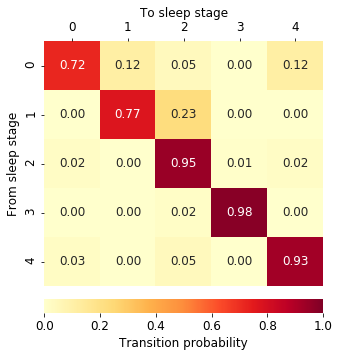

In [2]:
_, probs = yasa.transition_matrix(hypno_30s)

# Start the plot
grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(5, 5))
sns.heatmap(probs, ax=ax, square=False, vmin=0, vmax=1, cbar=True,
            cbar_ax=cbar_ax, cmap='YlOrRd', annot=True, fmt='.2f',
            cbar_kws={"orientation": "horizontal", "fraction": 0.1,
                      "label": "Transition probability"})
ax.set_xlabel("To sleep stage")
ax.xaxis.tick_top()
ax.set_ylabel("From sleep stage")
ax.xaxis.set_label_position('top')
# plt.savefig('transition.png', dpi=100, bbox_inches='tight')

### Spectrogram

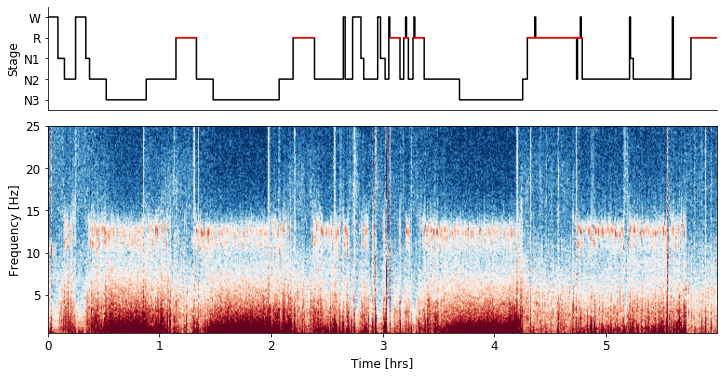

In [3]:
fig = yasa.plot_spectrogram(data[0, :], sf, hypno, trimperc=2.5)
# plt.savefig('spectrogram.png', dpi=100, bbox_inches='tight')

### Average spindles and slow-waves

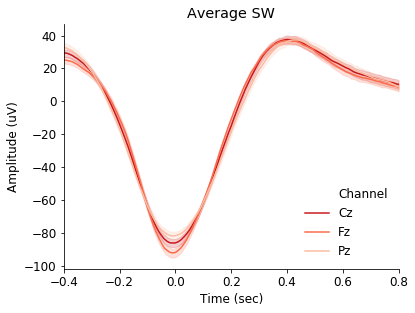

In [4]:
sw = yasa.sw_detect(data, sf, ch_names, hypno, include=(2, 3), coupling=True)
ax = sw.plot_average(palette="Reds_r", ci=99)
ax.legend(frameon=False)
sns.despine()
# plt.savefig('avgsw.png', dpi=100, bbox_inches='tight')

In [5]:
sw.summary()

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,PhaseAtSigmaPeak,ndPAC,Stage,Channel,IdxChannel
0,572.23,572.93,573.15,573.35,574.08,1.85,-73.967176,65.180112,139.147288,632.487671,0.540541,0.255100,0.202460,2,Cz,0
1,591.76,591.99,592.20,592.35,592.56,0.80,-112.435255,55.742974,168.178229,800.848709,1.250000,-1.173597,0.467261,2,Cz,0
2,631.90,632.16,632.74,632.96,633.18,1.28,-45.324262,43.926354,89.250616,153.880372,0.781250,1.340485,0.421982,2,Cz,0
3,644.24,644.60,644.78,644.96,645.14,0.90,-60.871638,65.217773,126.089411,700.496729,1.111111,1.174555,0.082714,2,Cz,0
4,645.14,645.31,645.54,645.86,646.07,0.93,-55.221932,36.132968,91.354901,397.195220,1.075269,1.174555,0.154057,2,Cz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8315,20523.90,20524.15,20524.34,20524.57,20525.06,1.16,-79.554617,86.822029,166.376645,875.666555,0.862069,1.804213,0.254594,2,Pz,2
8316,20525.58,20526.20,20526.47,20526.91,20527.37,1.79,-89.158120,52.157837,141.315957,523.392434,0.558659,1.804213,0.316573,2,Pz,2
8317,20531.52,20531.76,20531.99,20532.56,20532.86,1.34,-42.887941,66.835606,109.723547,477.058902,0.746269,-0.489004,0.147629,2,Pz,2
8318,20532.86,20533.35,20533.62,20533.81,20534.26,1.40,-59.099534,22.956090,82.055624,303.909720,0.714286,-0.489004,0.182458,2,Pz,2


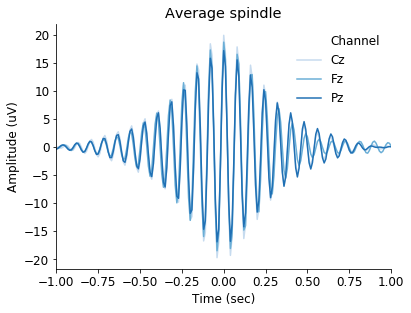

In [6]:
sp = yasa.spindles_detect(data, sf, ch_names, hypno, include=(2))
ax = sp.plot_average(filt=(12, 16), ci=None, palette="Blues")
ax.legend(frameon=False)
sns.despine()
# plt.savefig('avgsp.png', dpi=100, bbox_inches='tight')

### SO/spindles coupling

In [7]:
sw.summary(grp_chan=True)

,Count,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,PhaseAtSigmaPeak,ndPAC
Channel,,,,,,,,,
Cz,2855,1.126238,-82.763770,63.629536,146.393306,617.326004,0.968203,-0.178314,0.218587
Fz,2732,1.108748,-83.692100,59.767211,143.459310,622.423330,0.979340,-0.010715,0.225882
Pz,2733,1.160066,-80.817612,63.627486,144.445098,585.395453,0.941764,-0.306474,0.220317


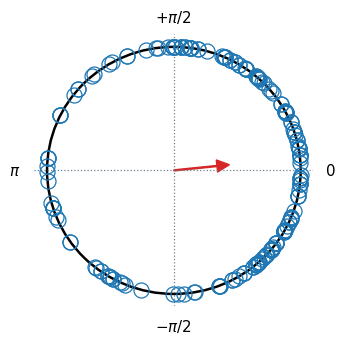

In [8]:
import pingouin as pg
events = sw.summary().query("Channel == 'Fz'").iloc[300:500]
ax = pg.plot_circmean(events['PhaseAtSigmaPeak'], kwargs_markers={'color': 'tab:blue', 'marker': 'o', 'mfc': 'none', 'ms': 12}, dpi=90)
# plt.savefig('coupling.png', dpi=100, bbox_inches='tight')

### Comodulogram

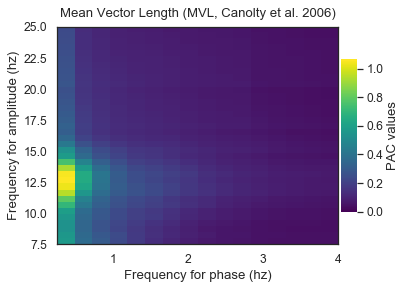

In [9]:
# Segment N2 sleep into 15-seconds  non-overlapping epochs
_, data_N2 = yasa.sliding_window(data[0, hypno == 2], sf, window=15)

# First, let's define our array of frequencies for phase and amplitude
f_pha = np.arange(0.125, 4.25, 0.25)  # Frequency for phase
f_amp = np.arange(7.25, 25.5, 0.5)  # Frequency for amplitude

from tensorpac import Pac
sns.set(font_scale=1.1, style='white')

# Define a PAC object
p = Pac(idpac=(1, 0, 0), f_pha=f_pha, f_amp=f_amp, verbose='WARNING')

# Filter the data and extract the PAC values
xpac = p.filterfit(sf, data_N2)

# Plot the comodulogram
p.comodulogram(xpac.mean(-1), title=str(p), vmin=0, plotas='imshow');
# plt.savefig('comod.png', dpi=100, bbox_inches='tight')

### Overlay

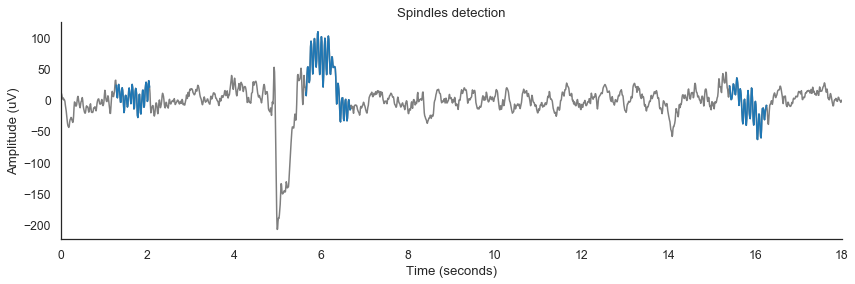

In [10]:
# Keep only 30-seconds of data
import mne
data_N2 = data[0, int(18164 * sf):int(18182 * sf)].astype(np.float64)
data_N2 = mne.filter.filter_data(data_N2, sf, 0.5, 30, verbose=False)

times_N2 = np.arange(data_N2.size) / sf

# Spindles detection
sp = yasa.spindles_detect(data_N2, sf)
events = sp.summary()
mask = sp.get_mask()

# Plot the signal
spindles_highlight = data_N2 * mask
spindles_highlight[spindles_highlight == 0] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
plt.plot(times_N2, data_N2, lw=1.5, color='tab:grey')
plt.plot(times_N2, spindles_highlight, lw=1.5, color='tab:blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times_N2[-1]])
plt.xticks(np.arange(0, 19, 2))
plt.title('Spindles detection')
sns.despine()
# plt.savefig('spoverlay.png', dpi=100, bbox_inches='tight')

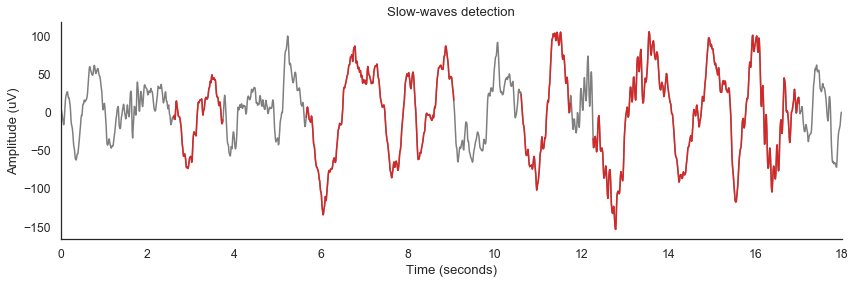

In [11]:
# Keep only 30-seconds of data
import mne
data_N3 = data[0, int(14105 * sf):int(14123 * sf)].astype(np.float64)
times_N3 = np.arange(data_N3.size) / sf
data_N3 = mne.filter.filter_data(data_N3, sf, 0.5, 30, verbose=False)

# Slow-waves detection
sw = yasa.sw_detect(data_N3, sf)
events = sw.summary()
mask = sw.get_mask()

# Plot the signal
sw_highlight = data_N3 * mask
sw_highlight[sw_highlight == 0] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
plt.plot(times_N3, data_N3, lw=1.5, color='tab:grey')
plt.plot(times_N3, sw_highlight, lw=1.5, color='tab:red')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times_N3[-1]])
plt.xticks(np.arange(0, 19, 2))
plt.title('Slow-waves detection')
sns.despine()
# plt.savefig('swoverlay.png', dpi=100, bbox_inches='tight')